In [1]:
import sys
import regions
#import pyavm
import numpy as np
import PIL

from regions import Regions

from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.visualization import simple_norm

import reproject 
from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import units as u

from reproject import reproject_interp

from spectral_cube import SpectralCube
from spectral_cube import Projection

from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D
from photutils import background

import regions
import cv2

from astropy.visualization.wcsaxes import add_scalebar
from astropy.visualization.wcsaxes import add_beam

import random as rand

from astropy.table import Table

In [2]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [3]:
import cutout_manager as cm
import moment_maker as mm

In [4]:
cd notebooks/

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


# Functions

In [5]:
def get_percentile_list(data, percents=[98, 99, 99.9, 99.99]):
    #[87, 95, 99, 99.5, 99.9, 99.99]
    arr = []
    for per in percents:
        arr.append(np.nanpercentile(data, per))
    return np.array(arr)

# Filament Cutouts

In [6]:
pos_ctr = SkyCoord('17:46:20.9063719501', '-28:37:51.6942550990', unit=(u.hourangle, u.deg))
#SkyCoord('17:46:20.5098134312', '-28:37:50.9694197729', unit=(u.hourangle, u.deg))
l = 6*u.arcmin#2.0*u.arcmin
w = 4*u.arcmin#1.0*u.arcmin

In [7]:
#rgb_data, rgb_wcs = cm.get_cutout_rgb(pos_ctr, l, w)

In [8]:
spitzer_data, spitzer_wcs = cm.get_cutout_glimpse_rgb(pos_ctr, w, l)

# CO Cube Cutouts

In [9]:
ls /orange/adamginsburg/cmz/nobeyama/

12CO-2.BEARS.FITS   13CO-2.S115Q.FITS   CS21.OGEO.SP.NEW.FITS
12CO-2.S115Q.FITS   C18O-2.FOREST.FITS
13CO-2.FOREST.FITS  CO3-2.ASTE.FITS


In [10]:
fn_12CO = '/orange/adamginsburg/cmz/nobeyama/12CO-2.BEARS.FITS'
fn_13CO = '/orange/adamginsburg/cmz/nobeyama/13CO-2.FOREST.FITS'
fn_C18O = '/orange/adamginsburg/cmz/nobeyama/C18O-2.FOREST.FITS'

In [11]:
cube_12CO = SpectralCube.read(fn_12CO, format='fits')
cube_13CO = SpectralCube.read(fn_13CO, format='fits')
cube_C18O = SpectralCube.read(fn_C18O, format='fits')

In [12]:
cube_12CO.moment0()

<Projection [[610.8017 , 586.0228 , 553.5477 , ..., 361.77405, 246.96346,
              194.48396],
             [618.32184, 586.9675 , 545.6661 , ..., 401.71716, 266.42648,
              201.4571 ],
             [609.1403 , 568.7315 , 518.3731 , ..., 470.0779 , 322.80582,
              248.90988],
             ...,
             [926.65955, 919.56195, 904.6144 , ..., 249.80156, 207.09212,
              168.09027],
             [889.4742 , 891.9199 , 887.50055, ..., 218.00249, 149.19206,
               93.97606],
             [845.5898 , 859.46075, 870.84906, ..., 211.00911, 116.23694,
               44.06427]] K km / s>

In [13]:
cube_12CO.header['RESTFRQ']

115271204000.0

In [14]:
cube_12CO.header['BUNIT']

'K'

In [15]:
cube_13CO.header['RESTFRQ']

110201353000.0

In [16]:
cube_C18O.header['RESTFRQ']

119782182000.0

In [17]:
mom0_12CO = mm.get_mom0(restfreq=cube_12CO.header['RESTFRQ']*u.Hz, filename=fn_12CO,vmin=-57*u.km/u.s, vmax=-53*u.km/u.s)#, vmin=-56*u.km/u.s, vmax=-54*u.km/u.s)
mom0_13CO = mm.get_mom0(restfreq=cube_13CO.header['RESTFRQ']*u.Hz, filename=fn_13CO,vmin=-57*u.km/u.s, vmax=-53*u.km/u.s)#, vmin=-56*u.km/u.s, vmax=-54*u.km/u.s)
mom0_C18O = mm.get_mom0(restfreq=cube_C18O.header['RESTFRQ']*u.Hz, filename=fn_C18O,vmin=-57*u.km/u.s, vmax=-53*u.km/u.s)#, vmin=-56*u.km/u.s, vmax=-54*u.km/u.s)

In [18]:
mom0_12CO_repj, _ = reproject_interp(mom0_12CO.hdu, spitzer_wcs.to_header(), shape_out=spitzer_data[:,:,0].shape)
hdu_12CO = fits.PrimaryHDU(mom0_12CO_repj, header=spitzer_wcs.to_header())
mom0_13CO_repj, _ = reproject_interp(mom0_13CO.hdu, spitzer_wcs.to_header(), shape_out=spitzer_data[:,:,0].shape)
hdu_13CO = fits.PrimaryHDU(mom0_13CO_repj, header=spitzer_wcs.to_header())
mom0_C18O_repj, _ = reproject_interp(mom0_C18O.hdu, spitzer_wcs.to_header(), shape_out=spitzer_data[:,:,0].shape)
hdu_C18O = fits.PrimaryHDU(mom0_C18O_repj, header=spitzer_wcs.to_header())

In [19]:
mom0_12CO_cutout = mm.get_mom0_cutout(pos_ctr, l, l, hdu_12CO)
mom0_13CO_cutout = mm.get_mom0_cutout(pos_ctr, l, l, hdu_13CO)
mom0_C18O_cutout = mm.get_mom0_cutout(pos_ctr, l, l, hdu_C18O)

In [20]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

subcube_12CO = cube_12CO.subcube_from_regions([reg])
subcube_12CO = subcube_12CO.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_12CO_mom0 = subcube_12CO.moment0()

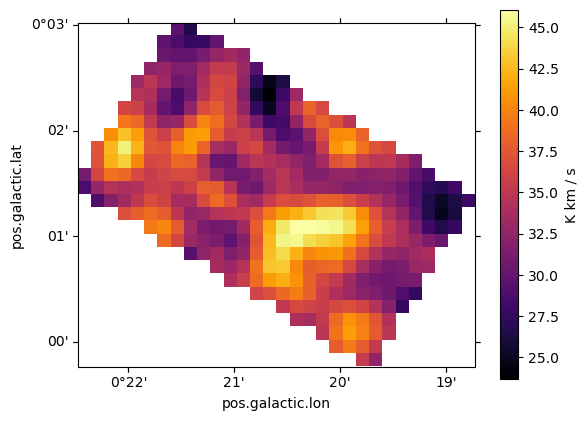

In [21]:
ax = plt.subplot(projection=subcube_12CO_mom0.wcs)
im = ax.imshow(subcube_12CO_mom0.value, origin='lower', cmap='inferno')
plt.colorbar(im, ax=ax, label=subcube_12CO_mom0.unit)

In [22]:
ww = subcube_12CO_mom0.wcs
subcube_N = np.nansum(subcube_12CO_mom0.value) * subcube_12CO_mom0.unit * 2.3 * 10**20 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
(subcube_N * pixel_area_physical * 2.8 * u.u).to(u.Msun)

<Quantity 2368.65646623 solMass>

In [23]:
ww = subcube_12CO_mom0.wcs
subcube_N = np.nansum(subcube_12CO_mom0.value) * subcube_12CO_mom0.unit * 1.5 * 10**19 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
(subcube_N * pixel_area_physical * 2.8 * u.u).to(u.Msun)

<Quantity 154.47759562 solMass>

In [24]:
ww = mom0_12CO_cutout.wcs
subcube_N = np.nansum(mom0_12CO_cutout.data) * subcube_12CO_mom0.unit * 2.3 * 10**20 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
(subcube_N * pixel_area_physical * 2.8 * u.u).to(u.Msun)

<Quantity 7373.18538231 solMass>

In [25]:
ww = mom0_12CO_cutout.wcs
subcube_N = np.nansum(mom0_12CO_cutout.data) * subcube_12CO_mom0.unit * 2.3 * 10**20 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 8 * u.kpc).to(u.cm, u.dimensionless_angles())**2
(subcube_N * pixel_area_physical * 2.8 * u.u).to(u.Msun)

<Quantity 18875.35457871 solMass>

In [26]:
ww = mom0_12CO_cutout.wcs
subcube_N = np.nansum(mom0_12CO_cutout.data) * subcube_12CO_mom0.unit * 2.3 * 10**20 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 6 * u.kpc).to(u.cm, u.dimensionless_angles())**2
(subcube_N * pixel_area_physical * 2.8 * u.u).to(u.Msun)

<Quantity 10617.38695052 solMass>

In [27]:
ww = mom0_12CO_cutout.wcs
subcube_N = np.nansum(mom0_12CO_cutout.data) * subcube_12CO_mom0.unit * 1.5 * 10**19 * u.cm**-2 * u.K**-1 * u.km**-1 * u.s
pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 8 * u.kpc).to(u.cm, u.dimensionless_angles())**2
(subcube_N * pixel_area_physical * 2.8 * u.u).to(u.Msun)

<Quantity 1231.00138557 solMass>

# Figures

In [28]:
percents = [90, 95, 98, 99]

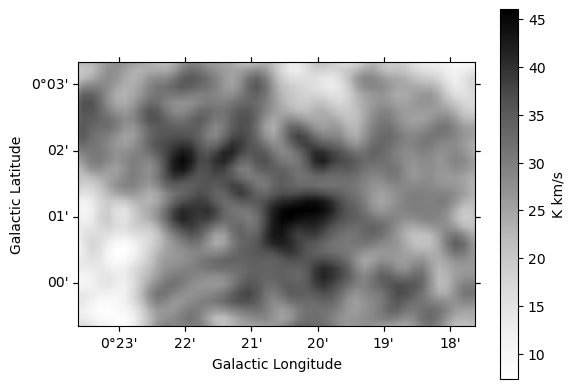

In [29]:
ax = plt.subplot(111, projection=mom0_12CO_cutout.wcs)
im = ax.imshow(mom0_12CO_cutout.data, cmap='Greys')

plt.colorbar(im, ax=ax, label='K km/s')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


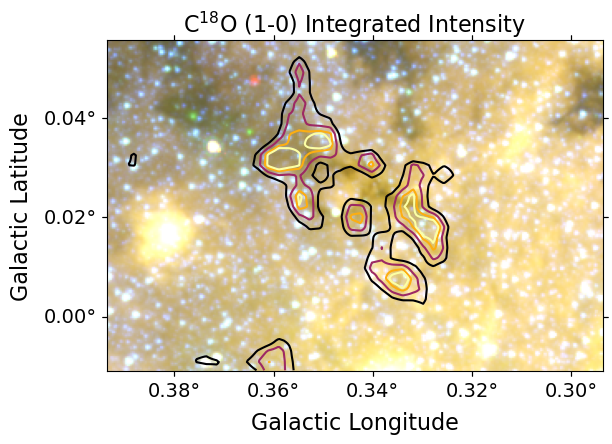

In [30]:
ax = plt.subplot(111, projection=spitzer_wcs)
ax.imshow(spitzer_data)
ax.contour(mom0_C18O_cutout.data, cmap='inferno', levels=get_percentile_list(mom0_C18O_cutout.data, percents=percents), transform=ax.get_transform(mom0_C18O_cutout.wcs))

ax.set_xlabel('Galactic Longitude', fontsize=16)
ax.set_ylabel('Galactic Latitude', fontsize=16)
ax.set_title(r'C$^{18}$O (1-0) Integrated Intensity', fontsize=16)
ax.tick_params(labelsize=14)
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')

plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/C18O_mom0_contour_filament.pdf', bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


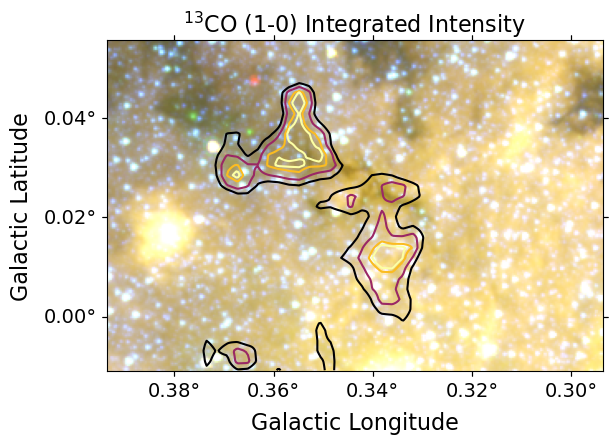

In [31]:
#plt.style.use('dark_background')
ax = plt.subplot(111, projection=spitzer_wcs)
ax.imshow(spitzer_data)
ax.contour(mom0_13CO_cutout.data, levels=get_percentile_list(mom0_13CO_cutout.data, percents=percents), 
            transform=ax.get_transform(mom0_13CO_cutout.wcs), cmap='inferno')

ax.set_xlabel('Galactic Longitude', fontsize=16)
ax.set_ylabel('Galactic Latitude', fontsize=16)
ax.set_title(r'$^{13}$CO (1-0) Integrated Intensity', fontsize=16)
ax.tick_params(labelsize=14)
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/13CO_mom0_contour_filament.pdf', bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


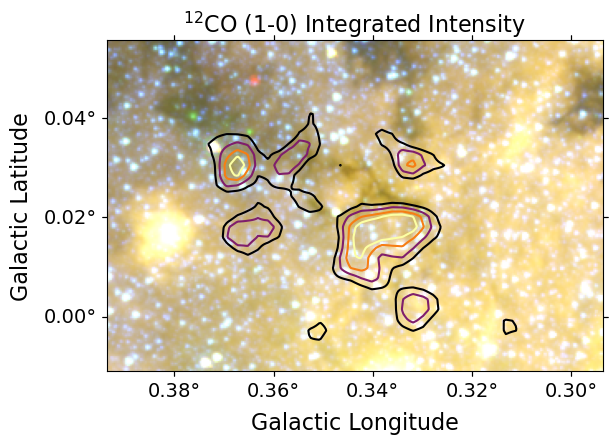

In [32]:
ax = plt.subplot(111, projection=spitzer_wcs)
ax.imshow(spitzer_data)
ax.contour(mom0_12CO_cutout.data, levels=get_percentile_list(mom0_12CO_cutout.data, percents=percents), 
            transform=ax.get_transform(mom0_12CO_cutout.wcs), cmap='inferno')

ax.set_xlabel('Galactic Longitude', fontsize=16)
ax.set_ylabel('Galactic Latitude', fontsize=16)
ax.set_title(r'$^{12}$CO (1-0) Integrated Intensity', fontsize=16)
ax.tick_params(labelsize=14)
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/12CO_mom0_contour_filament.pdf', bbox_inches='tight')

# Parent Cloud

In [33]:
pos_ctr = SkyCoord('17:46:20.9063719501', '-28:37:51.6942550990', unit=(u.hourangle, u.deg))
#SkyCoord('17:46:20.5098134312', '-28:37:50.9694197729', unit=(u.hourangle, u.deg))
l = 15*u.arcmin#2.0*u.arcmin
w = 15*u.arcmin#1.0*u.arcmin

In [34]:
spitzer_data, spitzer_wcs = cm.get_cutout_glimpse_rgb(pos_ctr, w, l)

In [35]:
reg_parent = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/filament_parent_cloud.reg')

cube_12CO_parent = cube_12CO#.subcube_from_regions(reg_parent).spectral_slab(-56*u.km/u.s, -54*u.km/u.s)
cube_13CO_parent = cube_13CO#.subcube_from_regions(reg_parent).spectral_slab(-56*u.km/u.s, -54*u.km/u.s)
cube_C18O_parent = cube_C18O#.subcube_from_regions(reg_parent).spectral_slab(-56*u.km/u.s, -54*u.km/u.s)

In [36]:
mom0_12CO_parent = mm.get_moment0(restfreq=cube_12CO_parent.header['RESTFRQ']*u.Hz, vmin=-57*u.km/u.s, vmax=-53*u.km/u.s, filename=fn_12CO)
mom0_13CO_parent = mm.get_moment0(restfreq=cube_13CO_parent.header['RESTFRQ']*u.Hz, vmin=-57*u.km/u.s, vmax=-53*u.km/u.s, filename=fn_13CO)
mom0_C18O_parent = mm.get_moment0(restfreq=cube_C18O_parent.header['RESTFRQ']*u.Hz, vmin=-57*u.km/u.s, vmax=-53*u.km/u.s, filename=fn_C18O)

AttributeError: module 'moment_maker' has no attribute 'get_moment0'

In [ ]:
mom0_12CO_repj, _ = reproject_interp(mom0_12CO_parent.hdu, spitzer_wcs.to_header(), shape_out=spitzer_data[:,:,0].shape)
hdu_12CO = fits.PrimaryHDU(mom0_12CO_repj, header=spitzer_wcs.to_header())
mom0_13CO_repj, _ = reproject_interp(mom0_13CO_parent.hdu, spitzer_wcs.to_header(), shape_out=spitzer_data[:,:,0].shape)
hdu_13CO = fits.PrimaryHDU(mom0_13CO_repj, header=spitzer_wcs.to_header())
mom0_C18O_repj, _ = reproject_interp(mom0_C18O_parent.hdu, spitzer_wcs.to_header(), shape_out=spitzer_data[:,:,0].shape)
hdu_C18O = fits.PrimaryHDU(mom0_C18O_repj, header=spitzer_wcs.to_header())

In [ ]:
mom0_12CO_parent_cutout = mm.get_mom0_cutout(pos_ctr, l, l, hdu_12CO)
mom0_13CO_parent_cutout = mm.get_mom0_cutout(pos_ctr, l, l, hdu_13CO)
mom0_C18O_parent_cutout = mm.get_mom0_cutout(pos_ctr, l, l, hdu_C18O)

In [ ]:
percents = [90, 95, 98, 99]

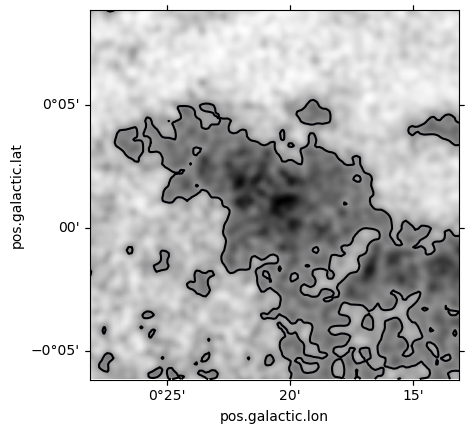

In [ ]:
ax = plt.subplot(111, projection=mom0_12CO_parent_cutout.wcs)
im = ax.imshow(mom0_12CO_parent_cutout.data, cmap='Greys')
ax.contour(mom0_12CO_parent_cutout.data, cmap='inferno', levels=[20], transform=ax.get_transform(mom0_12CO_parent_cutout.wcs))

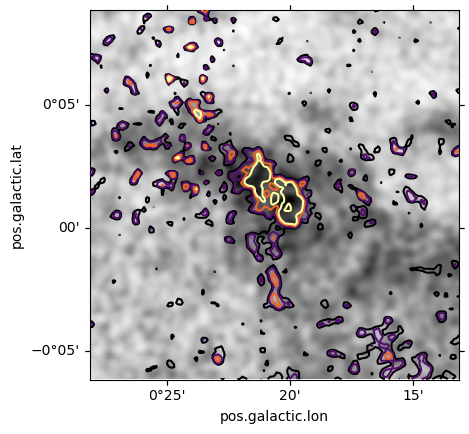

In [ ]:
ax = plt.subplot(111, projection=mom0_12CO_parent_cutout.wcs)
im = ax.imshow(mom0_12CO_parent_cutout.data, cmap='Greys')
ax.contour(mom0_CO_parent_cutout.data, cmap='inferno', levels=get_percentile_list(mom0_C18O_parent_cutout.data, percents=percents), transform=ax.get_transform(mom0_C18O_parent_cutout.wcs))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


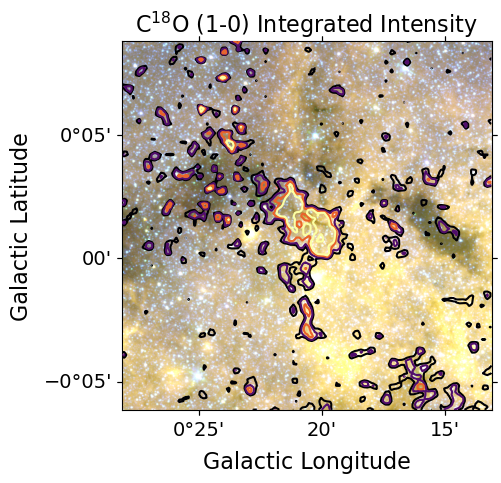

In [ ]:
ax = plt.subplot(111, projection=spitzer_wcs)
ax.imshow(spitzer_data)
ax.contour(mom0_C18O_parent_cutout.data, cmap='inferno', levels=get_percentile_list(mom0_C18O_parent_cutout.data, percents=percents), transform=ax.get_transform(mom0_C18O_parent_cutout.wcs))

ax.set_xlabel('Galactic Longitude', fontsize=16)
ax.set_ylabel('Galactic Latitude', fontsize=16)
ax.set_title(r'C$^{18}$O (1-0) Integrated Intensity', fontsize=16)
ax.tick_params(labelsize=14)

#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/C18O_mom0_contour_filament.pdf', bbox_inches='tight')

# JWST

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


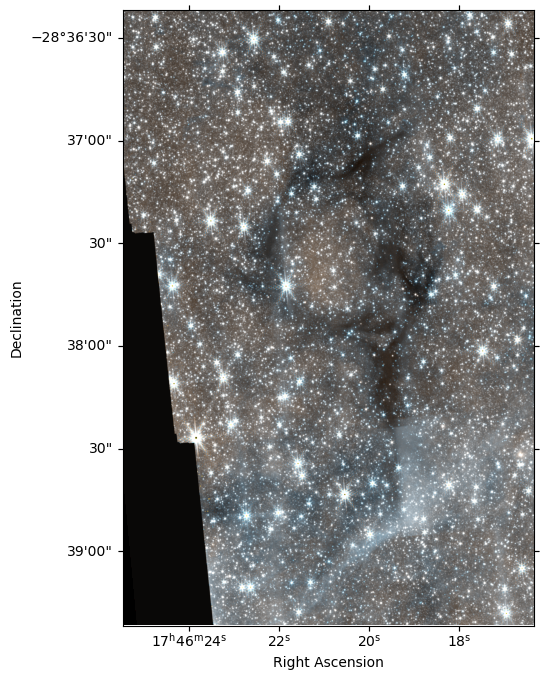

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=rgb_wcs)
ax.imshow(rgb_data, origin='lower')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

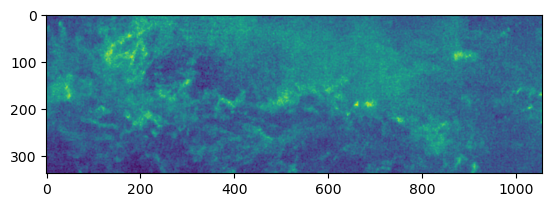

In [ ]:
mom0_12CO.quicklook()

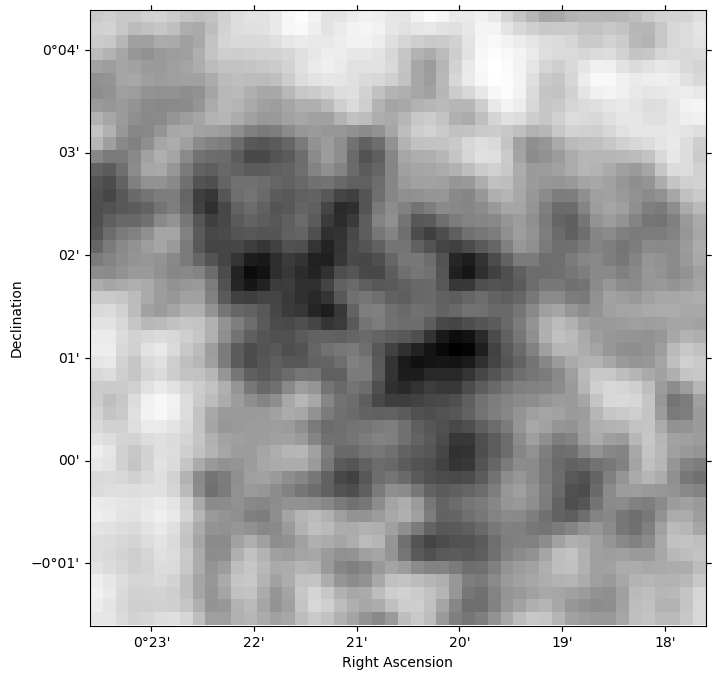

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=mom0_12CO_cutout.wcs)
ax.imshow(mom0_12CO_cutout.data, origin='lower', cmap='Greys')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

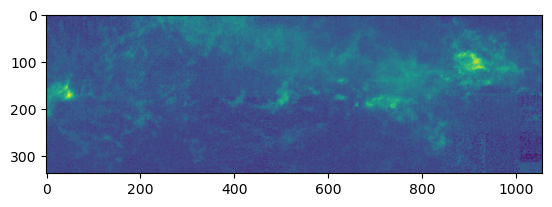

In [ ]:
mom0_13CO.quicklook()

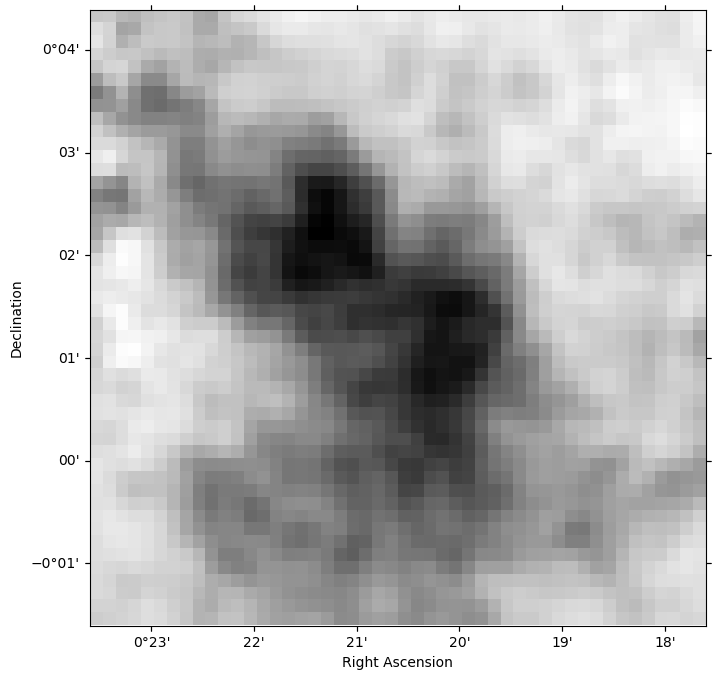

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=mom0_13CO_cutout.wcs)
ax.imshow(mom0_13CO_cutout.data, origin='lower', cmap='Greys')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

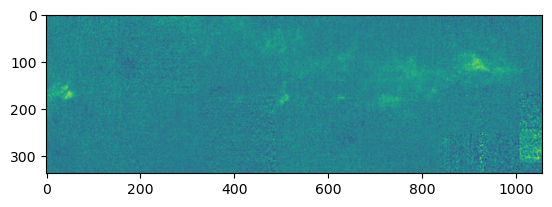

In [ ]:
mom0_C18O.quicklook()

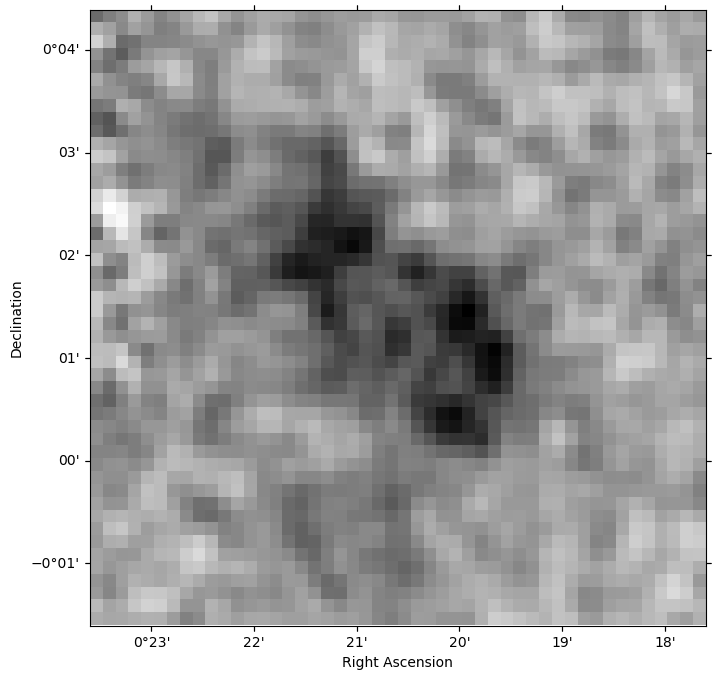

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=mom0_C18O_cutout.wcs)
ax.imshow(mom0_C18O_cutout.data, origin='lower', cmap='Greys')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')